### Initial Setup

In [24]:
# Install
!pip3 install matplotlib
!pip3 install scikit-image
!pip3 install scikit-learn

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [25]:
# Import
import os 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import zipfile 
from skimage import io 
from torch.utils.data import Dataset
import torch 
import pandas as pd 
from torchvision import transforms
import copy
from sklearn.metrics import mean_squared_error

In [26]:
# System Check
try:
  import google.colab
  from google.colab import drive
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False
try:
    hostname = !hostname
    if 'lab' in hostname[0] and '.eng.utah.edu' in hostname[0]:
        IN_CADE = True
    else:
        IN_CADE = False
except:
    IN_CADE = False

assert(not IN_CADE or not IN_COLAB)

In [27]:
# Find GPU
def define_gpu_to_use(minimum_memory_mb = 3800):
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        if free_memory>minimum_memory_mb-500:
            gpu_to_use = i
            break
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' +str(minimum_memory_mb) + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-500)).cuda()
        x = torch.rand((1,1)).cuda()
        del x

In [28]:
# Reserve GPU
if IN_CADE:
    define_gpu_to_use()

GPU already assigned before: 0


### Load and Visualize Dataset

In [29]:
# Opens zip file and places data in datsets folder
def open_zip(filename):
    zip_ref = zipfile.ZipFile(filename, 'r')
    zip_ref.extractall('datasets')
    zip_ref.close()

In [30]:
# Return indexes to split data by for train, val, and test
# Splits are 70% train, 10% val, 20% test
def get_split(array_to_split, split):
    np.random.seed(0)
    np.random.shuffle(array_to_split)
    np.random.seed()
    if split == 'train':
        array_to_split = array_to_split[:int(len(array_to_split)*0.7)]
    elif split == 'val':
        array_to_split = array_to_split[int(len(array_to_split)*0.7):int(len(array_to_split)*0.8)]
    elif split == 'test':
        array_to_split = array_to_split[int(len(array_to_split)*0.8):]
    return array_to_split

In [31]:
# Dataset class for Truss (Bracket/Beam) dataset
class TrussDataset(Dataset):
    def __init__(self, csv_file, root_dir, split='train'):
        self.root_dir = root_dir
        self.split = split
        # Get the split
        all_attributes_frame = pd.read_csv(root_dir + csv_file)
        ids = get_split(pd.unique(all_attributes_frame['ID']), split)
        self.attributes_frame = all_attributes_frame[all_attributes_frame['ID'].isin(ids)]
              
    def __len__(self):
        return len(self.attributes_frame)
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir, self.attributes_frame.iloc[idx, 1])
        image = io.imread(image_name)
        image = image.astype(np.float32)
        image = image[:,:,:3]
        image = image/255
        image = np.swapaxes(image, 0, 1)
        image = np.swapaxes(image, 0, 2)
        attributes = self.attributes_frame.iloc[idx, 2:].values
        attributes = attributes.astype('float')
        attribute_names = self.attributes_frame.columns[2:].values
        return torch.FloatTensor(image), torch.FloatTensor(attributes), list(attribute_names)

In [32]:
# Open zip of dataset
open_zip('trussData.zip')

In [33]:
# Create train, val, and test datasets
train_dataset = TrussDataset('truss_data.csv', 'datasets/trussData/')
val_dataset = TrussDataset('truss_data.csv', 'datasets/trussData/', split='val')
test_dataset = TrussDataset('truss_data.csv', 'datasets/trussData/', split='test')

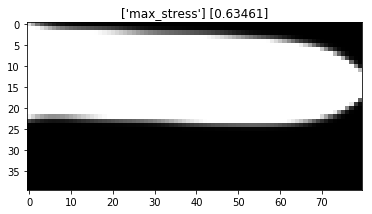

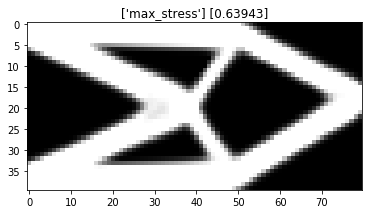

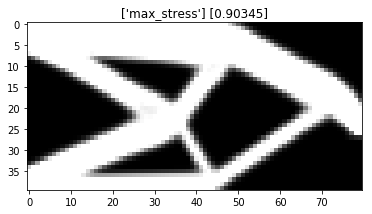

In [34]:
# Visualing a few cases of the training set
for batch_idx, (image, attribute, name) in enumerate(train_dataset):
    if batch_idx%250 == 0: 
        plt.figure()
        plt.title(str(name) + ' ' + str(attribute.cpu().numpy()))
        plt.imshow(image[:,:,:].permute([1, 2, 0]).cpu().numpy())

In [35]:
# Calculates L2 for images and MSE for regression - want both close to 0
def get_score_model(model, data_loader):
    model.eval()
    
    with torch.no_grad():
        distances = []
        mse = []
        for image, attribute, name in data_loader:
            image = image.cuda()
            recon, mu, logvar, reg = model(image)
            # Reconstruction Score
            euclidean_dist = torch.pow(torch.sum(torch.pow((image - recon), 2)), 0.5)
            distances.append(euclidean_dist.cpu().numpy())
            # Regression Score
            y_true = attribute.cpu().numpy()
            y_pred = reg.cpu().numpy()         
            mse.append(mean_squared_error(y_true, y_pred))
    
    return np.mean(distances), np.mean(mse)

In [36]:
# Classes to create VAE, ability to change kernel_size of filters for convolution layers
# and the latent representation dim
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ConvBlock, self).__init__()
        padding = int((kernel_size - 1) / 2)
        self.conv = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding)
        self.batch = torch.nn.BatchNorm2d(num_features=out_channels)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        return x

class TransBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransBlock, self).__init__()
        self.convT = torch.nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.convT(x)
        return x

class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class UnFlatten(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 32, 5, 10) # see if there is a way to not have this hardcoded

In [37]:
# VAE with Regression - The reconstruction and regression are done from the
# latent variables calculated from the reparametrization (distribution)
class VAE_REG(torch.nn.Module):
    def __init__(self, kernel_size, z_dim):
        super(VAE_REG, self).__init__()
        self.encoder = torch.nn.Sequential(
        ConvBlock(in_channels=3, out_channels=8, kernel_size=kernel_size),
        ConvBlock(in_channels=8, out_channels=8, kernel_size=kernel_size),
        torch.nn.MaxPool2d(kernel_size=2),
        ConvBlock(in_channels=8, out_channels=16, kernel_size=kernel_size),
        ConvBlock(in_channels=16, out_channels=16, kernel_size=kernel_size),
        torch.nn.MaxPool2d(kernel_size=2),
        ConvBlock(in_channels=16, out_channels=32, kernel_size=kernel_size),
        ConvBlock(in_channels=32, out_channels=32, kernel_size=kernel_size),
        torch.nn.MaxPool2d(kernel_size=2),
        Flatten()) 
        
        self.mu = torch.nn.Linear(1600, z_dim)
        self.logvar = torch.nn.Linear(1600, z_dim)
        self.fc = torch.nn.Linear(z_dim, 1600)
        
        self.decoder = torch.nn.Sequential(
        UnFlatten(),
        TransBlock(in_channels=32, out_channels=32),
        ConvBlock(in_channels=32, out_channels=32, kernel_size=kernel_size),
        ConvBlock(in_channels=32, out_channels=16, kernel_size=kernel_size),
        TransBlock(in_channels=16, out_channels=16),
        ConvBlock(in_channels=16, out_channels=16, kernel_size=kernel_size),
        ConvBlock(in_channels=16, out_channels=8, kernel_size=kernel_size),
        TransBlock(in_channels=8, out_channels=8),
        ConvBlock(in_channels=8, out_channels=8, kernel_size=kernel_size),
        ConvBlock(in_channels=8, out_channels=3, kernel_size=kernel_size))
        
        self.regression = torch.nn.Sequential(
            torch.nn.Linear(in_features=z_dim, out_features=4),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=4, out_features=1))
            
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.cuda.FloatTensor(mu.size()).normal_()
        z = mu + std * esp
        return z
    
    def bottleneck(self, x):
        mu, logvar = self.mu(x), self.logvar(x)
        z = self.reparametrize(mu, logvar)
        return z, mu, logvar
    
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]
    
    def decode(self, z):
        i = self.fc(z)
        i = self.decoder(i)
        r = self.regression(z)
        return i, r
    
    def forward(self, x):
        x = self.encoder(x)
        z, mu, logvar = self.bottleneck(x) # z is latent representation
        x = self.fc(z)
        x = torch.sigmoid(self.decoder(x)) # VAE output
        r = self.regression(z) # Regression output
        return x, mu, logvar, r

In [38]:
# Loss function for this task, combines reconstruction and KL for the image task and the MSELoss
# for the regression task
def loss_function(reconstruction, image, mu, logvar, attributes, r, batch_size):
    reconstruction_loss = torch.nn.functional.binary_cross_entropy(reconstruction, image)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss /=  batch_size * image.shape[1] * image.shape[2] * image.shape[3]
    reg_loss =  torch.nn.MSELoss()
    return reconstruction_loss, kl_loss, reg_loss(attributes, r)

In [39]:
# VAE conv kernel size = 7 z_dim=8
BATCH_SIZE = 10
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
train_loader_score = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

#instantiate your model here:
model = VAE_REG(kernel_size=7, z_dim=8)
model = model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
n_epochs = 200
# Learning rate is reduced after plateauing to stabilize the end of training.
# use the learning rate scheduler as defined here. Example on how to integrate it to training in
# https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)

train_recon_scores = []
train_r2_scores = []
val_recon_scores = []
val_r2_scores = []
target_score = 35.5 # Want score to be less than this
best_score = 50
best_model = copy.deepcopy(model)

print('Starting Training!')
for epoch in range(n_epochs):
    print('\nEpoch: ' + str(epoch))
    scheduler.step()
    
    model.train()
    
    total_losses = []
    reconstruction_losses = []
    kl_losses = []
    reg_losses = []
    for image, attribute, name in train_loader:
        optimizer.zero_grad()
        image = image.cuda()
        attribute = attribute.cuda()
        recon, mu, logvar, reg = model(image)
        reconstruction_loss, kl_loss, reg_loss = loss_function(recon, image, mu, logvar, attribute, reg, BATCH_SIZE)
        loss = reconstruction_loss + kl_loss + reg_loss
        loss.backward()
        optimizer.step()
        
        total_losses.append(loss.item())
        reconstruction_losses.append(reconstruction_loss.item())
        kl_losses.append(kl_loss.item())
        reg_losses.append(reg_loss.item())
        
    print('Total Loss: ' + str(np.mean(total_losses)))
    print('Reconstruction Loss: ' + str(np.mean(reconstruction_losses)))
    print('KL Loss: ' + str(np.mean(kl_losses)))
    print('Regression Loss: ' + str(np.mean(reg_losses)))
    
    # Get training data accuracy
    train_recon_score, train_r2 = get_score_model(model, train_loader_score)
    print('Trainig Reconstruction Score: ' + str(train_recon_score))
    print('Training MSE Score: ' + str(train_r2))
    train_recon_scores.append(train_recon_score)
    train_r2_scores.append(train_r2)
    
    # Get validation data accuracy
    val_recon_score, val_r2 = get_score_model(model, val_loader)
    print('Validation Reconstruction Score: ' + str(val_recon_score))
    print('Validation MSE Score: ' + str(val_r2))
    val_recon_scores.append(val_recon_score)
    val_r2_scores.append(val_r2)
    
    # Save Best Model - Based on Reconstruction Score
    if val_recon_score < target_score and val_recon_score < best_score:
        best_score = val_recon_score
        best_model = copy.deepcopy(model)
        print('New Best Model Saved!')

Starting Training!

Epoch: 0
Total Loss: 0.7455545272145953
Reconstruction Loss: 0.6665433040687017
KL Loss: 0.005705291113658209
Regression Loss: 0.07330592805686008
Trainig Reconstruction Score: 43.34823
Training MSE Score: 0.0080092605
Validation Reconstruction Score: 43.612984
Validation MSE Score: 0.0076063783

Epoch: 1
Total Loss: 0.6164488085678645
Reconstruction Loss: 0.6057737861360822
KL Loss: 0.004252069739491812
Regression Loss: 0.006422950174393398
Trainig Reconstruction Score: 41.222305
Training MSE Score: 0.005686346
Validation Reconstruction Score: 41.19124
Validation MSE Score: 0.0044383947

Epoch: 2
Total Loss: 0.5724767914840153
Reconstruction Loss: 0.5631562173366547
KL Loss: 0.0034452887385019236
Regression Loss: 0.005875287018716336
Trainig Reconstruction Score: 38.757465
Training MSE Score: 0.0052120932
Validation Reconstruction Score: 38.673004
Validation MSE Score: 0.004591614

Epoch: 3
Total Loss: 0.5445521763392858
Reconstruction Loss: 0.5361203517232622
KL L

Trainig Reconstruction Score: 33.48893
Training MSE Score: 0.0033215636
Validation Reconstruction Score: 33.707993
Validation MSE Score: 0.0030103452
New Best Model Saved!

Epoch: 27
Total Loss: 0.42301290929317475
Reconstruction Loss: 0.41676145025662015
KL Loss: 0.002889307658188045
Regression Loss: 0.0033621521034677116
Trainig Reconstruction Score: 33.521355
Training MSE Score: 0.0032769428
Validation Reconstruction Score: 33.741867
Validation MSE Score: 0.0033487426

Epoch: 28
Total Loss: 0.42243164735180994
Reconstruction Loss: 0.4162437894514629
KL Loss: 0.0028876817186496086
Regression Loss: 0.003300174543567534
Trainig Reconstruction Score: 33.48139
Training MSE Score: 0.0035445623
Validation Reconstruction Score: 33.707695
Validation MSE Score: 0.0030781818
New Best Model Saved!

Epoch: 29
Total Loss: 0.4216462301356452
Reconstruction Loss: 0.41545756033488684
KL Loss: 0.002898695266672543
Regression Loss: 0.0032899759094496923
Trainig Reconstruction Score: 33.47613
Training 

Total Loss: 0.4113945479903902
Reconstruction Loss: 0.40599122728620257
KL Loss: 0.0029577978953186953
Regression Loss: 0.0024455193604808302
Trainig Reconstruction Score: 33.116596
Training MSE Score: 0.0023273695
Validation Reconstruction Score: 33.397175
Validation MSE Score: 0.0031990246
New Best Model Saved!

Epoch: 54
Total Loss: 0.4112554839679173
Reconstruction Loss: 0.4058404760701316
KL Loss: 0.0029445755328716978
Regression Loss: 0.0024704294728248245
Trainig Reconstruction Score: 33.127728
Training MSE Score: 0.0022532896
Validation Reconstruction Score: 33.43769
Validation MSE Score: 0.003290557

Epoch: 55
Total Loss: 0.41079549406255994
Reconstruction Loss: 0.40546237996646334
KL Loss: 0.0029531170381233095
Regression Loss: 0.0023799968010280283
Trainig Reconstruction Score: 33.18979
Training MSE Score: 0.002337871
Validation Reconstruction Score: 33.507885
Validation MSE Score: 0.0034244529

Epoch: 56
Total Loss: 0.41105817769254954
Reconstruction Loss: 0.405749087248529

Total Loss: 0.4061074967895235
Reconstruction Loss: 0.4012941879885537
KL Loss: 0.002961670993162053
Regression Loss: 0.0018516378822304041
Trainig Reconstruction Score: 33.0045
Training MSE Score: 0.0016890584
Validation Reconstruction Score: 33.368732
Validation MSE Score: 0.0033523482

Epoch: 81
Total Loss: 0.406338443500655
Reconstruction Loss: 0.40152108924729485
KL Loss: 0.0029545205445694073
Regression Loss: 0.001862832934628906
Trainig Reconstruction Score: 33.029976
Training MSE Score: 0.0015823215
Validation Reconstruction Score: 33.40637
Validation MSE Score: 0.0031649536

Epoch: 82
Total Loss: 0.40598866045475007
Reconstruction Loss: 0.4011445535080774
KL Loss: 0.002965738288392978
Regression Loss: 0.0018783683057076164
Trainig Reconstruction Score: 33.040726
Training MSE Score: 0.0019399332
Validation Reconstruction Score: 33.403614
Validation MSE Score: 0.0032395395

Epoch: 83
Total Loss: 0.4058384563241686
Reconstruction Loss: 0.4011335722037724
KL Loss: 0.00295887089201

Total Loss: 0.40345496365002226
Reconstruction Loss: 0.39894602979932514
KL Loss: 0.002970817285989012
Regression Loss: 0.001538117479399911
Trainig Reconstruction Score: 32.94877
Training MSE Score: 0.0013392962
Validation Reconstruction Score: 33.31281
Validation MSE Score: 0.0030126085

Epoch: 108
Total Loss: 0.4030864200421742
Reconstruction Loss: 0.3986278453043529
KL Loss: 0.00296397842134216
Regression Loss: 0.001494596722269697
Trainig Reconstruction Score: 32.91064
Training MSE Score: 0.0013177637
Validation Reconstruction Score: 33.30395
Validation MSE Score: 0.002952037

Epoch: 109
Total Loss: 0.40313340510640827
Reconstruction Loss: 0.3986887991428375
KL Loss: 0.0029665421029286725
Regression Loss: 0.0014780639259177925
Trainig Reconstruction Score: 32.9293
Training MSE Score: 0.001347123
Validation Reconstruction Score: 33.31886
Validation MSE Score: 0.0032877424

Epoch: 110
Total Loss: 0.40304201926503863
Reconstruction Loss: 0.3986598930188588
KL Loss: 0.0029745233644332

Total Loss: 0.4011296830007008
Reconstruction Loss: 0.39701416577611653
KL Loss: 0.002967497001269034
Regression Loss: 0.001148020769843632
Trainig Reconstruction Score: 32.897217
Training MSE Score: 0.0012228449
Validation Reconstruction Score: 33.31005
Validation MSE Score: 0.0027886988

Epoch: 135
Total Loss: 0.401419677904674
Reconstruction Loss: 0.3971943472112928
KL Loss: 0.002967822950865541
Regression Loss: 0.0012575064012448171
Trainig Reconstruction Score: 32.869553
Training MSE Score: 0.0010984078
Validation Reconstruction Score: 33.286545
Validation MSE Score: 0.0029379884

Epoch: 136
Total Loss: 0.4011458886521203
Reconstruction Loss: 0.3969650055680956
KL Loss: 0.0029739070118271877
Regression Loss: 0.0012069765810987778
Trainig Reconstruction Score: 32.84546
Training MSE Score: 0.0009983428
Validation Reconstruction Score: 33.26086
Validation MSE Score: 0.0029819116

Epoch: 137
Total Loss: 0.401195256624903
Reconstruction Loss: 0.3969751455954143
KL Loss: 0.0029747056874

Validation Reconstruction Score: 33.20702
Validation MSE Score: 0.0027398667
New Best Model Saved!

Epoch: 161
Total Loss: 0.3982335554701941
Reconstruction Loss: 0.39440767892769407
KL Loss: 0.0029540065376620207
Regression Loss: 0.0008718717627094261
Trainig Reconstruction Score: 32.75627
Training MSE Score: 0.00083688967
Validation Reconstruction Score: 33.224964
Validation MSE Score: 0.0029714264

Epoch: 162
Total Loss: 0.39821035351072037
Reconstruction Loss: 0.39438809837613786
KL Loss: 0.002953385265677103
Regression Loss: 0.0008688686712827933
Trainig Reconstruction Score: 32.756687
Training MSE Score: 0.00085083686
Validation Reconstruction Score: 33.211544
Validation MSE Score: 0.0028300064

Epoch: 163
Total Loss: 0.39821174698216577
Reconstruction Loss: 0.3943555210317884
KL Loss: 0.0029551112159554448
Regression Loss: 0.0009011147591601392
Trainig Reconstruction Score: 32.757404
Training MSE Score: 0.00083648425
Validation Reconstruction Score: 33.221737
Validation MSE Scor

Validation Reconstruction Score: 33.227478
Validation MSE Score: 0.0027648862

Epoch: 188
Total Loss: 0.3979531381811414
Reconstruction Loss: 0.39413653782435826
KL Loss: 0.002957690038186099
Regression Loss: 0.0008589083777873643
Trainig Reconstruction Score: 32.750233
Training MSE Score: 0.0008158171
Validation Reconstruction Score: 33.228207
Validation MSE Score: 0.0028302527

Epoch: 189
Total Loss: 0.39791822007724215
Reconstruction Loss: 0.3941273983035769
KL Loss: 0.002957458614504763
Regression Loss: 0.0008333631031356552
Trainig Reconstruction Score: 32.749268
Training MSE Score: 0.0008037489
Validation Reconstruction Score: 33.220123
Validation MSE Score: 0.0028412268

Epoch: 190
Total Loss: 0.3979989060333797
Reconstruction Loss: 0.39419515430927277
KL Loss: 0.002958598712991391
Regression Loss: 0.0008451543590386532
Trainig Reconstruction Score: 32.74999
Training MSE Score: 0.0008011641
Validation Reconstruction Score: 33.219833
Validation MSE Score: 0.0028761062

Epoch: 191

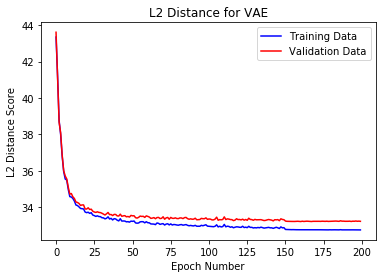

In [223]:
# Plot Training and Validation Score
plt.plot(range(n_epochs), train_recon_scores, 'b', range(n_epochs), val_recon_scores, 'r')
plt.title('L2 Distance for VAE +')
plt.legend(['Training Data', 'Validation Data'])
plt.xlabel('Epoch Number')
plt.ylabel('L2 Distance Score')
plt.savefig('L2Distance.png')
plt.show()

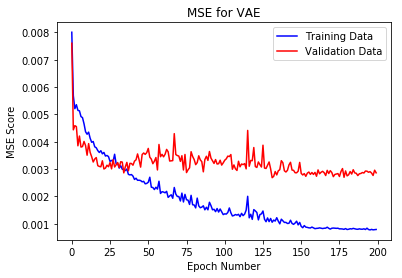

In [224]:
# Plot Training and Validation Score
plt.plot(range(n_epochs), train_r2_scores, 'b', range(n_epochs), val_r2_scores, 'r')
plt.title('MSE for VAE + Regression')
plt.legend(['Training Data', 'Validation Data'])
plt.xlabel('Epoch Number')
plt.ylabel('MSE Score')
plt.savefig('mse.png')
plt.show()

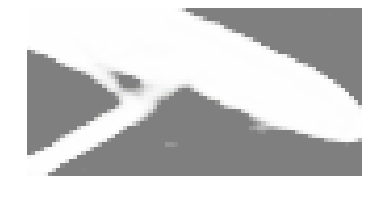

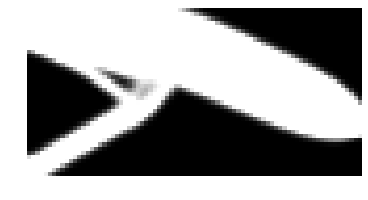

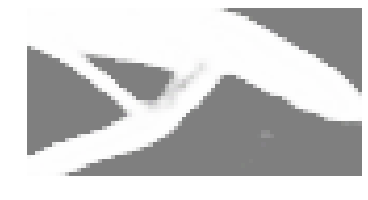

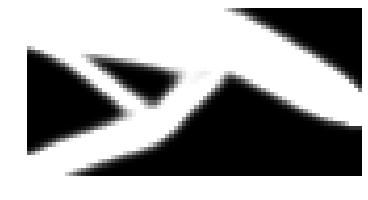

In [105]:
# Show examples of the ground truth image and the reconstruction after
# a pass through the autoencoder
def get_example_outputs(model, data_loader):
    model.eval()
    ground_truth = []
    model_output = []
    attribute_gt = []
    attribute_reg = []
    with torch.no_grad():
        for image, attribute, name in data_loader:
            image = image.cuda()
            recon, mu, var, r = model(image)
            model_output.append(recon)
            ground_truth.append(image)
            attribute_gt.append(attribute)
            attribute_reg.append(r)
            if len(model_output) == 2:
                return model_output, ground_truth, attribute_gt, attribute_reg
            
model_out, gt, attribute_gt, attribute_reg = get_example_outputs(model, val_loader)
for idx in range(2):
    plt.figure()
    plt.axis('off')
#     plt.title("Reconstruction " + str(idx))
    model_out[idx] = model_out[idx].view(model_out[idx].shape[1], model_out[idx].shape[2], model_out[idx].shape[3])
    plt.imshow(model_out[idx].permute([1, 2, 0]).cpu().numpy())
    plt.figure()
    plt.axis('off')
#     plt.title("Original Image " + str(idx))
    gt[idx] = gt[idx].view(gt[idx].shape[1], gt[idx].shape[2], gt[idx].shape[3])
    plt.imshow(gt[idx].permute([1, 2, 0]).cpu().numpy())

In [43]:
print(attribute_gt)
print(attribute_reg)

[tensor([[0.7161]]), tensor([[0.7896]])]
[tensor([[0.7263]], device='cuda:0'), tensor([[0.7644]], device='cuda:0')]


In [44]:
test_recon_score, test_mse_score = get_score_model(best_model, test_loader)
print('Test L2 Score: ' + str(test_recon_score))
print('Test MSE Score: ' + str(test_mse_score))

Test L2 Score: 33.16023
Test MSE Score: 0.0026877983


In [1]:
# Generated Examples
sample = torch.randn(1, 8)
sample = sample.cuda()
model.eval()
sample, r = model.decode(sample)
sample = sample.view(sample.shape[1], sample.shape[2], sample.shape[3])
sample = sample.permute([1, 2, 0])
sample = sample.cpu().detach().numpy()
plt.figure()
plt.axis('off')
plt.imshow(sample)
plt.savefig('image.png')

NameError: name 'torch' is not defined

In [222]:
print(r)

tensor([[0.5789]], device='cuda:0', grad_fn=<AddmmBackward>)
